# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
env = gym.make('BipedalWalker-v2')

random_seed = 10
env.seed(random_seed)

# from agent import Agent
# agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0], 
#               random_seed=random_seed)

[10]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
env.action_space, env.observation_space

(Box(4,), Box(24,))

In [4]:
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]

In [5]:
action_size, state_size

(4, 24)

In [6]:
env.observation_space.low, env.observation_space.high

(array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf], dtype=float32),
 array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       dtype=float32))

In [7]:
env.action_space.low, env.action_space.high

(array([-1., -1., -1., -1.], dtype=float32),
 array([1., 1., 1., 1.], dtype=float32))

### 3. Instantiate DDPG Agent

In [8]:
from agent2 import Agent

agent = Agent(s_size=state_size, a_size=action_size, random_seed=random_seed)

### 4. Train the Agent with DDPG

In [9]:
from collections import deque
import numpy as np
import time
import torch

n_episodes=1000
# n_steps=1000
# n_learn=10
# learn_every=20
R_goal=0 # TOCHECK
Rs_deque = deque(maxlen=100)
meanRs = [] # plot
Rs = [] # plot
dlosses = []
glosses = []

In [ ]:
for i_episode in range(n_episodes):
    
    # # Reset Env
    # env_info = env.reset(train_mode=train_mode)[brain_name]       # reset the environment    
    # S = env_info.vector_observations                   # get the current state (for each agent)
    s = env.reset() # s: state [-1:1, -1:1, -8:8]
    #print(s.shape)

    #Rs = np.zeros(num_agents)                            # initialize the score (for each agent)
    R = 0 # R: total reward
    gloss_batch = []
    dloss_batch = []

    #for i_step in range(n_steps):
    while True:
        s = np.reshape(s, [1, -1])
        a = agent.act(s) # a=[-2, 2]
        #a *= 2
        #print(a.shape)
        
        # Exploration noise
        # noise = np.random.normal(loc=0, scale=0.1, size=[num_agents, action_size])
        # A += noise
        # A = np.clip(a=A, a_min=-1, a_max=1)

        # env_info = env.step(A)[brain_name]            # send all actions to the environment
        # S2 = env_info.vector_observations          # get next state (for each agent)
        # rewards = env_info.rewards                          # get reward (for each agent)
        # dones = env_info.local_done                         # see if episode finished
        #s2: next_state, r: reward, done/terminal, env: environment
        a = np.reshape(a, [-1])
        s2, r, done, _ = env.step(a)
        #print(s2.shape, r, done)

        #s2_, q_ = agent.env(s, a)
        a = np.reshape(a, [1, -1])
        #s2_, _ = agent.env(s, a)
        # print(s2_)
        # s2_ = np.tanh(s2_) # predicted next state [-1:1, -1:1, -8:8]
        # print(s2_)
        # s2_[2] = s2_[2] * 8
        # print(s2_)

        # for s, a, reward, s2, done in zip(S, A, rewards, S2, dones):
        # agent.step(state, action, reward, next_state, done) # send actions to the agent
        agent.step(s, a, r, s2, done)

        R += r                           # update the score (for each agent)
        s = s2                                # roll over the states to the next state

        # if i_step%learn_every == 0:
        losses = []
        for _ in range(10):
            dloss = agent.start_dlearn()
            #print(dloss)
            losses.append(dloss)
        dloss_batch.append(np.mean(losses))
            
        #print(len(agent.memory))
        gloss = agent.start_glearn()
        gloss_batch.append(gloss)

        # if np.any(dones):                                   # exit loop if episode finished
        #     break
        if done:
            break

    #meanR = np.mean(Rs)
    #Rs_deque.append(meanR)
    Rs_deque.append(R)
    meanRs.append(np.mean(Rs_deque)) # plot
    Rs.append(R) # plot
    dlosses.append(np.mean(dloss_batch))
    glosses.append(np.mean(gloss_batch))

    print('\rEpisode {}\tTotal Average Score: {:.2f}\tGloss: {:.2f}, \tDloss: {:.2f}'.format(
           i_episode+1, np.mean(Rs_deque), np.mean(gloss_batch), np.mean(dloss_batch)))  
    if np.mean(Rs_deque) >= R_goal:
        torch.save(agent.g.state_dict(), 'g-bipedal.pth')
        torch.save(agent.d.state_dict(), 'd-bipedal.pth')
        break

### 5. Plot the result

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

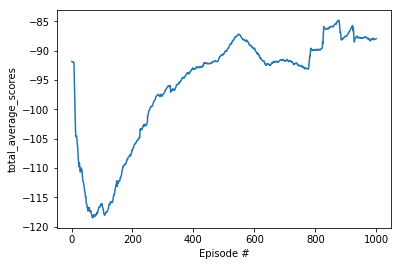

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

### 6. Watch the agent running with saved weights

In [36]:
# Load the saved weights into Pytorch model
agent.g.load_state_dict(torch.load('g-bipedal.pth', map_location='cpu'))
agent.d.load_state_dict(torch.load('d-bipedal.pth', map_location='cpu'))

# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# S = env_info.vector_observations                  # get the current states (S) (for each agent)
s = env.reset() # s: state # get the current state (s) (for an agent)
s_ = np.zeros_like(s)# s_: predicted state # predict the current state (s) (by the agent)
# print(s.shape)

#Rs = np.zeros(num_agents)                          # initialize the total scores (Rs) (for each agent)
R = 0 # R:total reward # initialize the total score (R) (for an agent)

while True:
    #A = agent.act(S)                        # select actions (A) from loaded model agents
    s = np.reshape(s, [1, -1])
    s_ = np.reshape(s_, [1, -1])
    a = agent.act(s, s_) # a: [-1, +1]    # select action (a) from loaded model agent
    #a = agent.act(s)
    #print(s.shape, a.shape)
    
    # env_info = env.step(A)[brain_name]           # send all actions (A) to tne environment (env)
    # S2 = env_info.vector_observations         # get next states (S2) (for each agent)
    # rewards = env_info.rewards                         # get rewards (for each agent)
    # dones = env_info.local_done                        # see if the episode is done/finished (terminal)
    s2, r, done, _ = env.step(np.reshape(a, [-1]))
    #s2, r, done = env.step(a)
    
    #s2_, q_ = agent.env(s, a)
    s2_, _ = agent.env(s, a)
    
    # Rs += env_info.rewards                         # update the total scores (Rs) (for each agent)
    # S = S2                               # roll over current states (S) to next states (S2)
    R += r # update the total score (R) (for an agent)
    s = s2 # roll over current state (s) to next state (s2)
    s_ = s2_ # roll over the predcited current state (s) to the predicted next state (s2_)
    
    #if np.any(dones):                                  # exit loop if episode is done/finished
    if done: # exit loop if episode is done/finished (terminal)
        break
        
print('Average of total scores: {}'.format(R))

Average of total scores: -106.75700939138544


When finished, you can close the environment.

In [37]:
env.close()